In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import pyslim as psl

In [65]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200
#plt.style.use('./buffalo.mplstyle')

In [71]:
data_dir = '../data/slim_sims/polygenic_nonwf/'

In [66]:
file = '../data/slim_sims/polygenic_Vs1_fitfuncoptimashift_optimasdNA_optima_shift0.5_K500_alpha0.01_muT1e-08_muN0_rbp1e-08_log.tsv'
dl = pd.read_csv(file, delimiter='\t')

In [67]:
dl.head()

,generation,z_mean,z_sd,nmuts_mean,nmuts_sd,optima
0,1,0.000000,0.000000,0.00000,0.00000,0.0
1,11,-0.000943,0.026539,9.70755,3.62055,0.0
2,21,-0.003452,0.043074,20.38580,4.95010,0.0
3,31,0.001858,0.053286,30.40440,5.70525,0.0
4,41,0.001800,0.062210,40.50000,6.53633,0.0


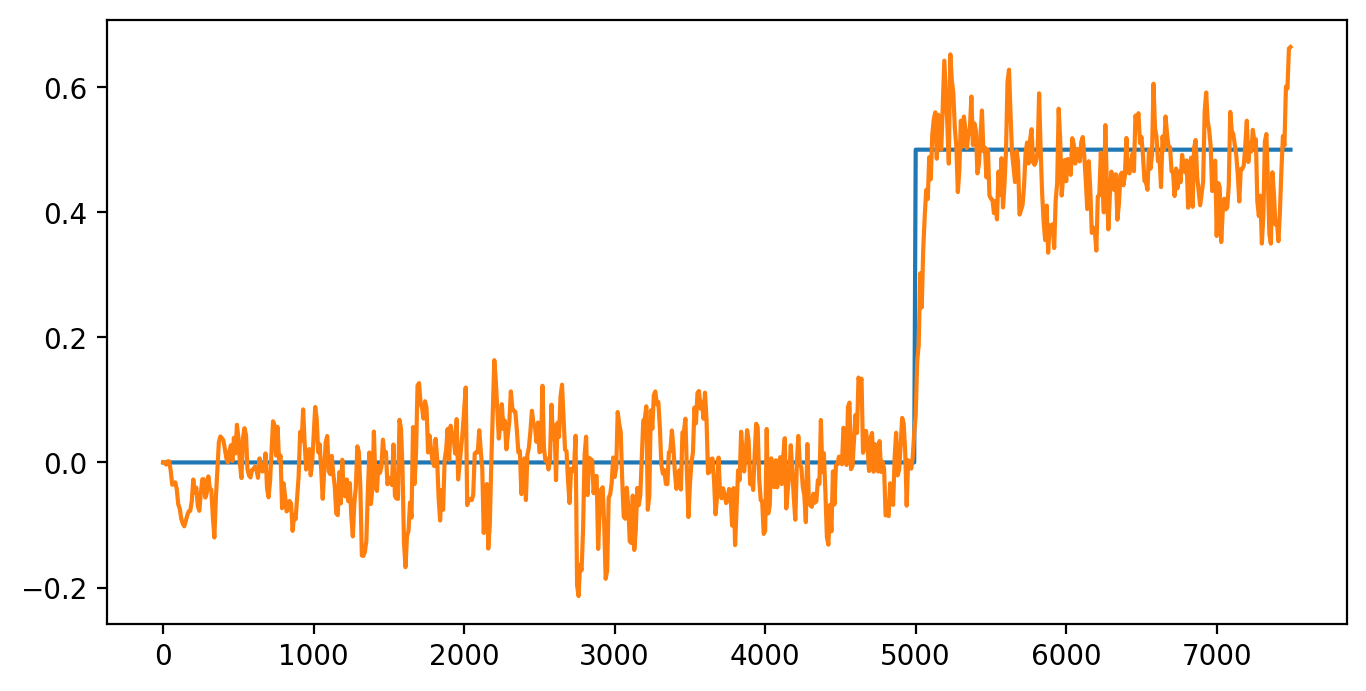

In [68]:
plt.plot(dl.generation, dl.optima)
plt.plot(dl.generation, dl.z_mean)

In [69]:
file = '../data/slim_sims/polygenic_Vs1_fitfuncoptimashift_optimasdNA_optima_shift0.5_K500_alpha0.01_muT1e-08_muN0_rbp1e-08_treeseq.tree'
ts = psl.load(file)

/home/vsb/miniconda3/envs/bioinfo/lib/python3.8/site-packages/pyslim/slim_tree_sequence.py:868: UserWarning: This is an version 0.6 SLiM tree sequence. When you write this out, it will be converted to version 0.5.
  warnings.warn("This is an version {} SLiM tree sequence.".format(file_version) +


In [70]:
ts.diversity()

array(5.83664564e-06)